# Random Forest
### Trainer : - Rajesh Jakhotia

In [1]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


In [2]:
#Load the Dataset
RFDF_dev = pd.read_csv("DEV_SAMPLE.csv")
RFDF_holdout = pd.read_csv("HOLDOUT_SAMPLE.csv")

In [3]:
print( RFDF_dev.shape,  RFDF_holdout.shape)

(14000, 10) (6000, 10)


In [4]:
RFDF_dev.head(10)

,Cust_ID,Target,Age,Gender,Balance,Occupation,No_OF_CR_TXNS,AGE_BKT,SCR,Holding_Period
0,C16505,0,41,M,91519.92,SELF-EMP,38,41-45,926,15
1,C17241,0,52,M,117288.96,SAL,17,>50,768,13
2,C18802,0,31,F,259827.44,SENP,8,31-35,816,5
3,C19289,0,45,F,26677.55,PROF,14,41-45,353,18
4,C14028,0,39,F,43440.31,SENP,1,36-40,751,31
5,C17960,0,45,M,403324.49,SENP,11,41-45,364,2
6,C10216,1,33,M,245500.00,SAL,24,31-35,166,9
7,C4575,0,26,F,464931.92,SELF-EMP,18,26-30,448,28
8,C6171,0,38,M,49257.03,SAL,19,36-40,237,5
9,C484,1,44,M,10791.71,SELF-EMP,17,41-45,678,3


In [5]:
## Get Frequency of 0 and 1
target_freq = pd.crosstab(index=RFDF_dev['Target'], 
                             columns="count",
                             )

target_freq['prop'] = target_freq/target_freq.sum()
target_freq

col_0,count,prop
Target,,
0,12765,0.911786
1,1235,0.088214


In [6]:
#Data Preprocessing
#Splitting into features and response variables
X =  RFDF_dev[['Age', 'Gender', 'Balance', 'Occupation',
               'No_OF_CR_TXNS', 'AGE_BKT', 'SCR', 'Holding_Period']]

#Categorical Variable to Numerical Variables
X_train = pd.get_dummies(X)
print(X_train.columns)


y_train = RFDF_dev["Target"]

print (type(X_train) , type(y_train))

Index(['Age', 'Balance', 'No_OF_CR_TXNS', 'SCR', 'Holding_Period', 'Gender_F',
       'Gender_M', 'Gender_O', 'Occupation_PROF', 'Occupation_SAL',
       'Occupation_SELF-EMP', 'Occupation_SENP', 'AGE_BKT_26-30',
       'AGE_BKT_31-35', 'AGE_BKT_36-40', 'AGE_BKT_41-45', 'AGE_BKT_46-50',
       'AGE_BKT_<25', 'AGE_BKT_>50'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


### Random Forest Classifier using RandomizedSearchCV

In [7]:
## Tuning the Random Forest using RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 125, num = 5)]
# Number of features to consider at every split
max_features = [2,3,4]
# Maximum number of levels in tree
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,}
print(random_grid)


{'n_estimators': [50, 68, 87, 106, 125], 'max_features': [2, 3, 4], 'min_samples_split': [100, 200, 300, 400, 500]}


In [8]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(warm_start = True)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 10, cv = 10, scoring = 'roc_auc',
                               verbose=2, random_state=1212, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(warm_start=True),
                   n_jobs=-1,
                   param_distributions={'max_features': [2, 3, 4],
                                        'min_samples_split': [100, 200, 300,
                                                              400, 500],
                                        'n_estimators': [50, 68, 87, 106, 125]},
                   random_state=1212, scoring='roc_auc', verbose=2)

In [9]:
rf_random.best_params_

{'n_estimators': 125, 'min_samples_split': 200, 'max_features': 4}

In [10]:
rf_random.best_score_

0.787213511554034

In [11]:
best_rf_clf = rf_random.best_estimator_

In [12]:
## Hold out performance
X_holdout =  RFDF_holdout[['Age', 'Gender', 'Balance', 'Occupation',
               'No_OF_CR_TXNS', 'AGE_BKT', 'SCR', 'Holding_Period']]
X_test = pd.get_dummies(X_holdout)
RFDF_holdout["Predict_score"] = best_rf_clf.predict_proba(X_test)[:,1]
roc_auc_score(RFDF_holdout["Target"],
              RFDF_holdout["Predict_score"])

0.7773420107182638

### Rank Ordering & KS

In [13]:
## decile code
def deciles(x):
    decile = pd.Series(index=[0,1,2,3,4,5,6,7,8,9])
    for i in np.arange(0.1,1.1,0.1):
        decile[int(i*10)]=x.quantile(i)
    def z(x):
        if x<decile[1]:
            return(1)
        elif x<decile[2]:
            return(2)
        elif x<decile[3]:
            return(3)
        elif x<decile[4]:
            return(4)
        elif x<decile[5]:
            return(5)
        elif x<decile[6]:
            return(6)
        elif x<decile[7]:
            return(7)
        elif x<decile[8]:
            return(8)
        elif x<decile[9]:
            return(9)
        elif x<=decile[10]:
            return(10)
        else:
            return(np.NaN)
    s=x.map(z)
    return(s) 

In [14]:
def RO_Table(X,y,Target):
    X['decile']=deciles(X[y])
    Rank=X.groupby('decile').apply(lambda x: pd.Series([
        np.min(x[y]),
        np.max(x[y]),
        np.mean(x[y]),
        np.size(x[y]),
        np.sum(x[Target]),
        np.size(x[Target][x[Target]==0]),
        ],
        index=(["min_resp","max_resp","avg_resp","cnt","cnt_resp","cnt_non_resp"])
        )).reset_index()
    Rank = Rank.sort_values(by='decile',ascending=False)
    Rank["rrate"] = round(Rank["cnt_resp"]*100/Rank["cnt"],2)
    Rank["cum_resp"] = np.cumsum(Rank["cnt_resp"])
    Rank["cum_non_resp"] = np.cumsum(Rank["cnt_non_resp"])
    Rank["cum_resp_pct"] = round(Rank["cum_resp"]/np.sum(Rank["cnt_resp"]),2)
    Rank["cum_non_resp_pct"] = round(Rank["cum_non_resp"]/np.sum(Rank["cnt_non_resp"]),2)
    Rank["KS"] = round(Rank["cum_resp_pct"] - Rank["cum_non_resp_pct"],2)
    Rank
    return(Rank)


Rank_holdout = RO_Table(RFDF_holdout,"Predict_score","Target")
KS_hold = max(Rank_holdout.KS)

print(" KS Holdout Sample : " , KS_hold)


 KS Holdout Sample :  0.41


In [15]:
Rank_holdout

,decile,min_resp,max_resp,avg_resp,cnt,cnt_resp,cnt_non_resp,rrate,cum_resp,cum_non_resp,cum_resp_pct,cum_non_resp_pct,KS
9,10,0.178520,0.454627,0.241966,600.0,176.0,424.0,29.33,176.0,424.0,0.35,0.08,0.27
8,9,0.134559,0.178368,0.154355,600.0,96.0,504.0,16.00,272.0,928.0,0.55,0.17,0.38
7,8,0.107671,0.134555,0.120228,600.0,67.0,533.0,11.17,339.0,1461.0,0.68,0.27,0.41
6,7,0.083849,0.107549,0.094763,600.0,46.0,554.0,7.67,385.0,2015.0,0.77,0.37,0.40
5,6,0.065458,0.083839,0.074526,600.0,36.0,564.0,6.00,421.0,2579.0,0.85,0.47,0.38
4,5,0.048613,0.065408,0.056214,600.0,27.0,573.0,4.50,448.0,3152.0,0.90,0.57,0.33
3,4,0.038121,0.048597,0.043065,600.0,14.0,586.0,2.33,462.0,3738.0,0.93,0.68,0.25
2,3,0.029722,0.038094,0.033700,600.0,20.0,580.0,3.33,482.0,4318.0,0.97,0.78,0.19
1,2,0.021596,0.029719,0.025748,600.0,7.0,593.0,1.17,489.0,4911.0,0.98,0.89,0.09
0,1,0.006652,0.021590,0.016497,600.0,9.0,591.0,1.50,498.0,5502.0,1.00,1.00,0.00


### Variable Importance

In [16]:
# !pip3 install scikit-plot

Features sorted by their importance:
0.3095 Holding_Period
0.1659 No_OF_CR_TXNS
0.1372 Balance
0.1072 SCR
0.0778 Occupation_SELF-EMP
0.0426 Occupation_SENP
0.0423 Age
0.0389 Occupation_SAL
0.0147 Gender_F
0.013 AGE_BKT_41-45
0.0123 Occupation_PROF
0.0121 Gender_M
0.0055 Gender_O
0.004 AGE_BKT_>50
0.0038 AGE_BKT_36-40
0.0036 AGE_BKT_<25
0.0035 AGE_BKT_26-30
0.0034 AGE_BKT_31-35
0.0027 AGE_BKT_46-50


<Axes: title={'center': 'Feature Importance'}>

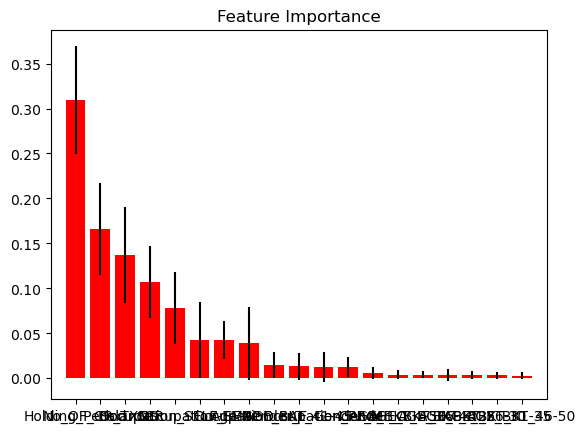

In [17]:
## Plot Variable Importance
## pip install scikit-plot
import scikitplot as skplt
names = X_train.columns
names 

feat_imp = sorted(
            zip(map(lambda x: round(x, 4), best_rf_clf.feature_importances_), 
                names), 
            reverse=True
            )

print ("Features sorted by their importance:")
for s in feat_imp:
    print(*s)

skplt.estimators.plot_feature_importances(best_rf_clf,  feature_names = names )


### Thank you